In [1]:

suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(caret, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(mgcv, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(require(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(glmnet, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(margins, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(pROC, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(plotmo, quietly = TRUE, warn.conflicts = FALSE))

set.seed(2718281)


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand


Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Lo

### In this module you will learn:


1. How to classify credit card defaults based on observable characteristics
2. Examine goodness-of-fit measures for classification
3. Explore generalized additive models in R
4. Explore shrinkage of nonlinear models

### The Data

The credit card default data is from Taiwan in 2005. We don't have too many covariates to examine, but the ones we do have should be informative. Let's look at the raw data to see the names and descriptions:

| Covariate Name | Description                         |
|----------------|-------------------------------------|
| LIMIT_BAL      | Amt of credit available             |
| SEX            | Indicator for sex                   |
| AGE            | Age                                 |
| PAY            | Denotes deliquency in past periods  |                     
| BILL_AMT       | Denotes amount due in past periods  |
| PAY_AMT        | Denotes amount paid in past periods |
| educ           | Indicator for Education Level       |
| marr           | Indicator for marital status        |
| default        | Indicator for default status        |

Alright now that we know what the variable names correspond to, let's load in the data.


In [2]:
defaults = read.csv('default.csv')   
# Reads csv files into R
defaults[1:10,1:10]                               
# Examine the first few rows of our data                        
cat('Dataset dimesions: ', dim(defaults))            
# Returns the dimension of the dataset 
defaults$default = as.factor(defaults$default)

LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1
20000,1,24,2,2,-1,-1,-2,-2,3913
120000,1,26,-1,2,0,0,0,2,2682
90000,1,34,0,0,0,0,0,0,29239
50000,1,37,0,0,0,0,0,0,46990
50000,0,57,-1,0,-1,0,0,0,8617
50000,0,37,0,0,0,0,0,0,64400
500000,0,29,0,0,0,0,0,0,367965
100000,1,23,0,-1,-1,0,0,-1,11876
140000,1,28,0,0,2,0,0,0,11285
20000,0,35,-2,-2,-2,-2,-1,-1,0


Dataset dimesions:  30000 31

## Validation Split in Discrete Data

One thing we have to be careful about in classification is how we split the sample to preserve the balance of the data. Let's see what proportion of the sample actually defaults.

proportion of defaults:  0.2840267

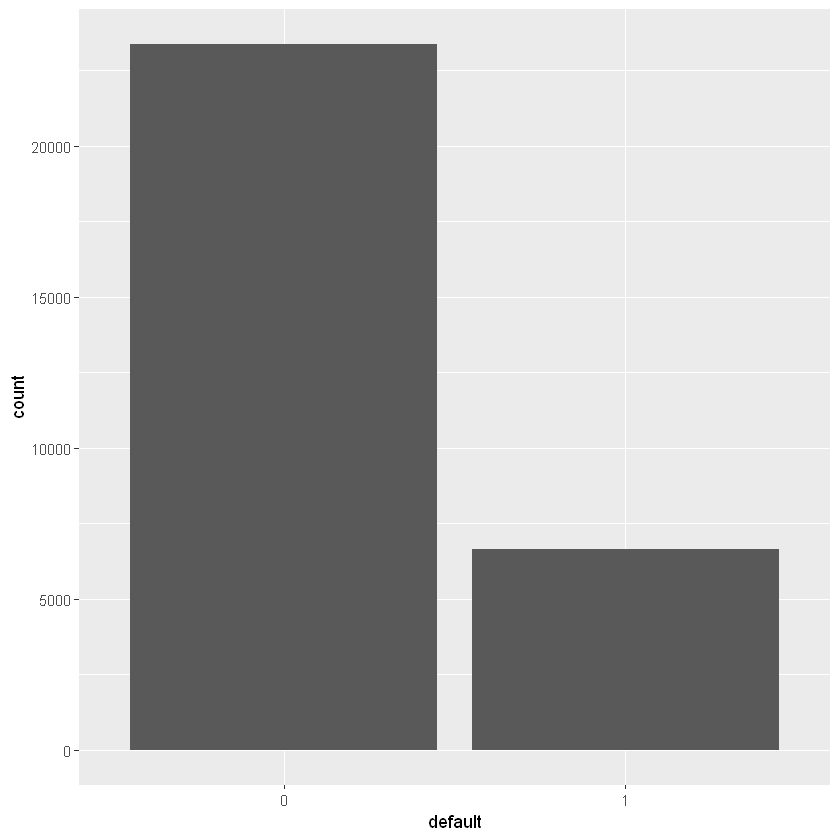

In [3]:
ggplot(defaults, aes(default)) + geom_bar()
cat('proportion of defaults: ', sum(defaults$default==1)/sum(defaults$default==0))

It looks like a bit more than $\frac{1}{4}$ of the sample defaults. As we did before, let's split our data into train-test-validation sets, but this time we are going to use the built in 'createDataPartition' function. We want to make sure that our splits preserve this proportion. This function will automatically balance the splits based on a specified covariate. In this case we are balancing on $default$.

In [4]:
## Splitting the data
trainIndex = createDataPartition(defaults$default, p = .9,
                                  list = FALSE, 
                                  times = 1)
train_test = defaults[trainIndex,]
validation = defaults[-trainIndex,]


## Building a Classifier

To get started we can train a very simple classifier based only on $SEX$, $AGE$, $EDUC$, $MARR$, and $LIMIT$_$BAL$. The simple classifier will use logistic regression. This is very easy to implement in R. The only changes we have to make in the train function is to specify "glm" instead of "lm" and change the "family" to binomial. Let's examine the model.

In [5]:
train1 = cbind(train_test[c('default','SEX','AGE','LIMIT_BAL')],
               select(train_test,starts_with('educ')),
           select(train_test,starts_with('marr')))


# Lets just do a single split here into train-test

tmp = createDataPartition(train1$default, p = .8,
                                  list = FALSE, 
                                  times = 1)
train_tmp = train1[tmp,]
test_tmp = train1[-tmp,]


Logistic = glm(default~., data= train_tmp, family='binomial')       
#GLM (generalized linear model) with family=binomial

summary(Logistic)


Call:
glm(formula = default ~ ., family = "binomial", data = train_tmp)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9684  -0.7678  -0.6480  -0.4127   2.9233  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.304e+01  1.220e+02  -0.107   0.9148    
SEX         -1.656e-01  3.405e-02  -4.863 1.16e-06 ***
AGE          2.076e-03  2.065e-03   1.005   0.3147    
LIMIT_BAL   -3.325e-06  1.581e-07 -21.033  < 2e-16 ***
educ.._1     1.094e+01  1.220e+02   0.090   0.9285    
educ.._2     1.097e+01  1.220e+02   0.090   0.9283    
educ.._3     1.096e+01  1.220e+02   0.090   0.9284    
educ.._4     9.566e+00  1.220e+02   0.078   0.9375    
educ.._5     9.052e+00  1.220e+02   0.074   0.9408    
educ.._6     1.060e+01  1.220e+02   0.087   0.9308    
marr.._1     1.485e+00  6.032e-01   2.462   0.0138 *  
marr.._2     1.277e+00  6.033e-01   2.117   0.0343 *  
marr.._3     1.311e+00  6.215e-01   2.109   0.0349 *  
---
Signif. codes:  0 '***' 

## Intepreting the Classifier

This is the full output from our logistic regression. Remember unlike the linear model, the coefficients themselves do not have a direct interpretation. However, we do care about the statistical significance of the parameters. We can see that in this particular specification the most important factors are sex and limit balance. These results are consistent with other findings. The "SEX" variable indicates the individual is Female and the sign is negative, i.e. Females are less likely to default than Males (ceteris paribus). Naturally, a higher limit balance should indicate a lower likelihood of default.

## What about Marginal Effects?

Since we can't directly interpret the coefficients as marginal effects we need to perform an extra step. We can get average marginal effects for all covariates in the model using the margins package.

In [6]:
m = suppressWarnings(margins(Logistic))
summary(m)

factor,AME,SE,z,p,lower,upper
AGE,3.469478e-04,3.450374e-04,1.00553683,3.146384e-01,-3.293130e-04,1.023209e-03
educ.._1,1.827587e+00,2.038050e+01,0.08967330,9.285468e-01,-3.811746e+01,4.177263e+01
educ.._2,1.833441e+00,2.038050e+01,0.08996056,9.283186e-01,-3.811160e+01,4.177849e+01
educ.._3,1.831570e+00,2.038050e+01,0.08986876,9.283915e-01,-3.811347e+01,4.177661e+01
educ.._4,1.598581e+00,2.038064e+01,0.07843626,9.374810e-01,-3.834674e+01,4.154391e+01
educ.._5,1.512672e+00,2.038059e+01,0.07422122,9.408344e-01,-3.843255e+01,4.145789e+01
educ.._6,1.770643e+00,2.038062e+01,0.08687874,9.307679e-01,-3.817464e+01,4.171593e+01
LIMIT_BAL,-5.556140e-07,2.604589e-08,-21.33211597,5.716278e-101,-6.066630e-07,-5.045650e-07
marr.._1,2.481500e-01,1.007763e-01,2.46238396,1.380168e-02,5.063204e-02,4.456680e-01
marr.._2,2.133971e-01,1.008019e-01,2.11699609,3.426018e-02,1.582913e-02,4.109651e-01



## Visualizing Marginal Effects

This table may be a bit overwhelming when we have many covariates. It may be easier to visualize these effects directly. Let's just examine the effects over the range of $LIMIT$_$BAL$

    xvals      yvals      upper      lower
1   10000 0.30929124 0.32927953 0.28930295
2   51250 0.28078296 0.29870918 0.26285673
3   92500 0.25393631 0.27015850 0.23771413
4  133750 0.22883983 0.24372081 0.21395886
5  175000 0.20554032 0.21941171 0.19166893
6  216250 0.18404690 0.19718017 0.17091362
7  257500 0.16433613 0.17692781 0.15174445
8  298750 0.14635767 0.15853014 0.13418520
9  340000 0.13004000 0.14185350 0.11822651
10 381250 0.11529590 0.12676530 0.10382650
11 422500 0.10202744 0.11313878 0.09091610
12 463750 0.09013039 0.10085441 0.07940636
13 505000 0.07949779 0.08979990 0.06919568
14 546250 0.07002297 0.07986983 0.06017612
15 587500 0.06160183 0.07096532 0.05223834
16 628750 0.05413448 0.06299377 0.04527520
17 670000 0.04752648 0.05586867 0.03918429
18 711250 0.04168954 0.04950956 0.03386951
19 752500 0.03654196 0.04384189 0.02924203
20 793750 0.03200874 0.03879685 0.02522062


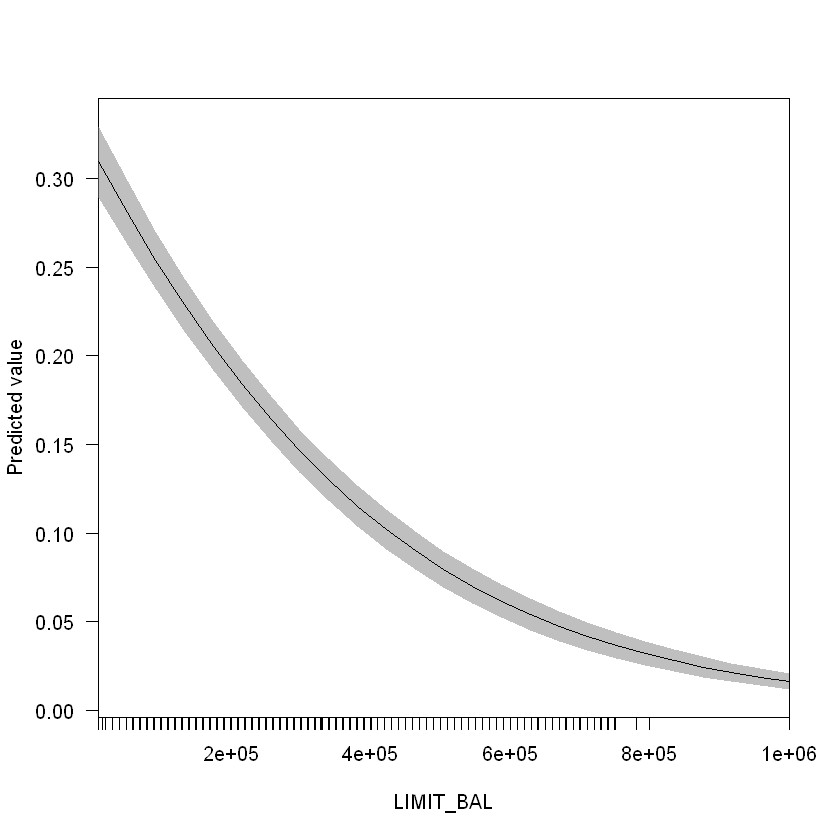

In [7]:
cplot(Logistic, "LIMIT_BAL")

As we expect the probability of default decreases with an increased limit balance, but at a decreasing rate.

## A Visualization for Goodness-of-fit

Now let's go ahead and look at the ROC (Receiver operating characteristics) curve. This is really just a way to graph the confusion matrix. The idea is to use sensitivity = True Positives / (True Positives + False Negatives) and specificity = True Negative / (True Negative + False Positive) and plot the tradeoff. Depending on the scenario in question one may prefer one over the other, but in general one wants to maximize the AUC (area under the curve).

Training AUC:  0.6249897
 Test AUC:  0.6255964

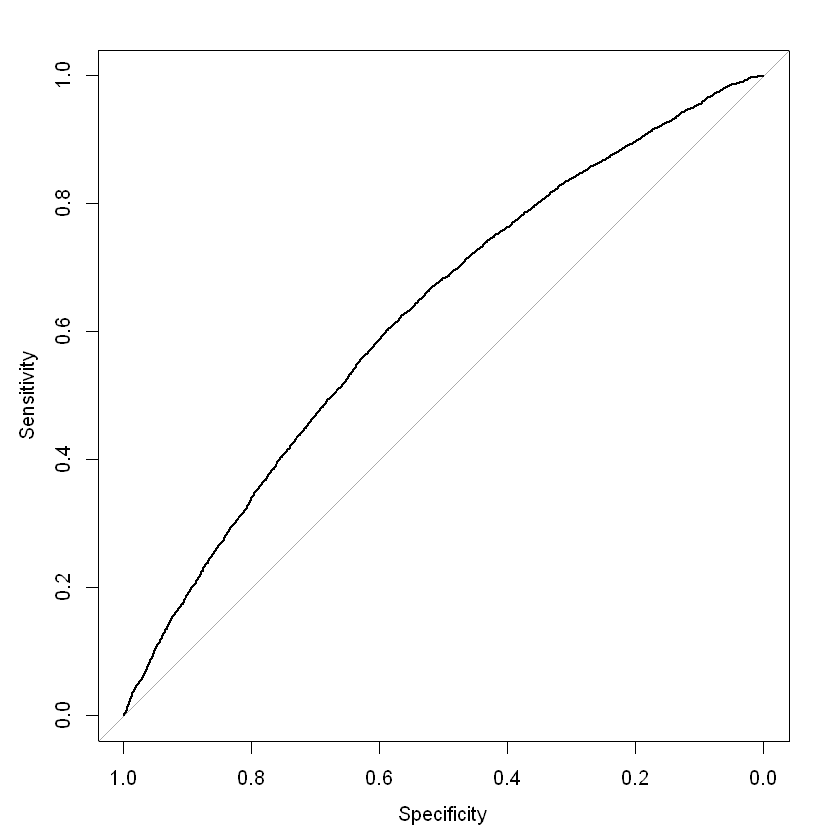

In [8]:
ROC = roc(train_tmp$default,Logistic$fitted.values)
plot(ROC)
cat('Training AUC: ', auc(ROC))

ROC = roc(test_tmp$default,predict(Logistic,newdata = test_tmp))
cat('\n Test AUC: ', auc(ROC))

## How did we do?

The simple classifier doesn't do too poorly. Training and test set performance are about the same, but we should be able to obtain better performance by including the remaining covariates. Add the covariates relating to past payment and bill balances using the select() command and run the new regression model.

In [9]:
train2 = cbind(train1,select(train_test,starts_with('PAY')),
               select(train_test,starts_with('BILL')))

tmp = createDataPartition(train2$default, p = .8,
                                  list = FALSE, 
                                  times = 1)
train_tmp = train2[tmp,]
test_tmp = train2[-tmp,]

Logistic = glm(default~., data= train_tmp, family='binomial')

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

How does our ROC improve by adding these covariates?

Training AUC:  0.7297437
 Test AUC:  0.7184873

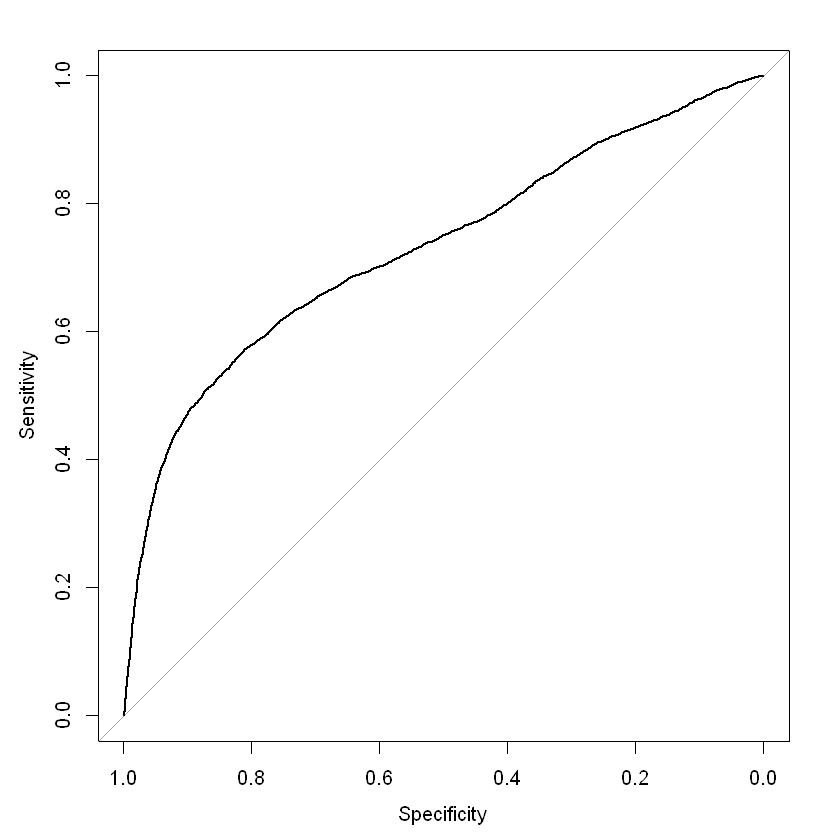

In [10]:
ROC = roc(train_tmp$default,Logistic$fitted.values)
plot(ROC)
cat('Training AUC: ', auc(ROC))

ROC = roc(test_tmp$default,predict(Logistic,newdata = test_tmp))
cat('\n Test AUC: ', auc(ROC))


## Improving our Classifier

Looks like adding the additional information helped quite a bit. However, we may be interested in other functional forms for the model.
There are many options for flexible functional forms. The most common way is to add higher order terms (polynomials) as we did in the first module. Another common method is to use a cubic spline. Let's consider a very simple extension of the previous model. The only difference will be the $LIMIT$_$BAL$ variable enters the model as an argument of an unknown function. The extension of GLM in this form is called a GAM (Generalized Additive Model).

In R we can use the GAM package to estimate these types of models. One thing to keep in mind is the formula must be specified here. The model we are looking at is exactly the same as the previous one except we apply a cubic spline to $LIMIT$_$BAL$, $PAY$_$AMT1$, and $BILL$_$AMT1$. This is denoted by "s()" with the option set to "cr".

In [11]:
formula = as.formula(paste("default~", paste(colnames(train2[, !names(train2) %in% 
                    c("default","LIMIT_BAL","PAY_AMT1","BILL_AMT")]), 
                    collapse="+"),'+s(LIMIT_BAL, bs="cr")',
                    '+s(PAY_AMT1, bs="cr")',
                    '+s(BILL_AMT1, bs="cr")'))

Logistic = gam(formula, data= train_tmp, family='binomial')
summary(Logistic)



Family: binomial 
Link function: logit 

Formula:
default ~ SEX + AGE + educ.._1 + educ.._2 + educ.._3 + educ.._4 + 
    educ.._5 + educ.._6 + marr.._1 + marr.._2 + marr.._3 + PAY_0 + 
    PAY_2 + PAY_3 + PAY_4 + PAY_5 + PAY_6 + PAY_AMT2 + PAY_AMT3 + 
    PAY_AMT4 + PAY_AMT5 + PAY_AMT6 + BILL_AMT1 + BILL_AMT2 + 
    BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6 + s(LIMIT_BAL, 
    bs = "cr") + s(PAY_AMT1, bs = "cr") + s(BILL_AMT1, bs = "cr")

Parametric coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.996e+01  4.655e+05   0.000  0.99995    
SEX         -1.043e-01  3.705e-02  -2.814  0.00489 ** 
AGE          3.522e-03  2.246e-03   1.568  0.11691    
educ.._1     2.776e+01  4.655e+05   0.000  0.99995    
educ.._2     2.770e+01  4.655e+05   0.000  0.99995    
educ.._3     2.766e+01  4.655e+05   0.000  0.99995    
educ.._4     2.630e+01  4.655e+05   0.000  0.99995    
educ.._5     2.648e+01  4.655e+05   0.000  0.99995    
educ.._6     2.738e+01  4.655e+0

Notice that $LIMIT$_$BAL$, $PAY$_$AMT1$, and $BILL$_$AMT1$ are now described at the end of summary and are called a "smooth term". We can once again evaluate the ROC curve for this model.

Training AUC:  0.7581318
 Test AUC:  0.7471815

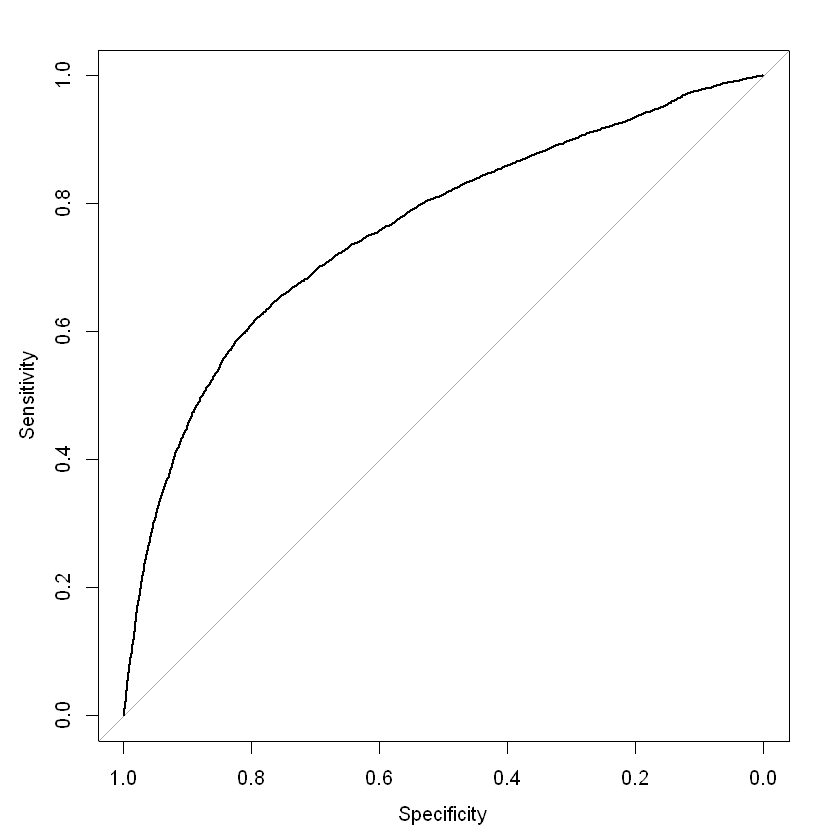

In [12]:
ROC = roc(train_tmp$default,Logistic$fitted.values)
plot(ROC)
cat('Training AUC: ', auc(ROC))

ROC = roc(test_tmp$default,predict(Logistic,newdata = test_tmp))
cat('\n Test AUC: ', auc(ROC))



## Evaluating the GAM

We get an improvement in test performance in this case. One caveat to adding smoothing terms to the model is that they can overfit. There are various ways of handling this, but penalization can and is used in this setting as well. We can do both of these things at once, but for simplicity let's go back to the full model without the smooth terms.

## Shrinkage in Nonlinear Models

The same penalty terms can be used in nonlinear models as they were in the linear case. Let's use LASSO on our model.




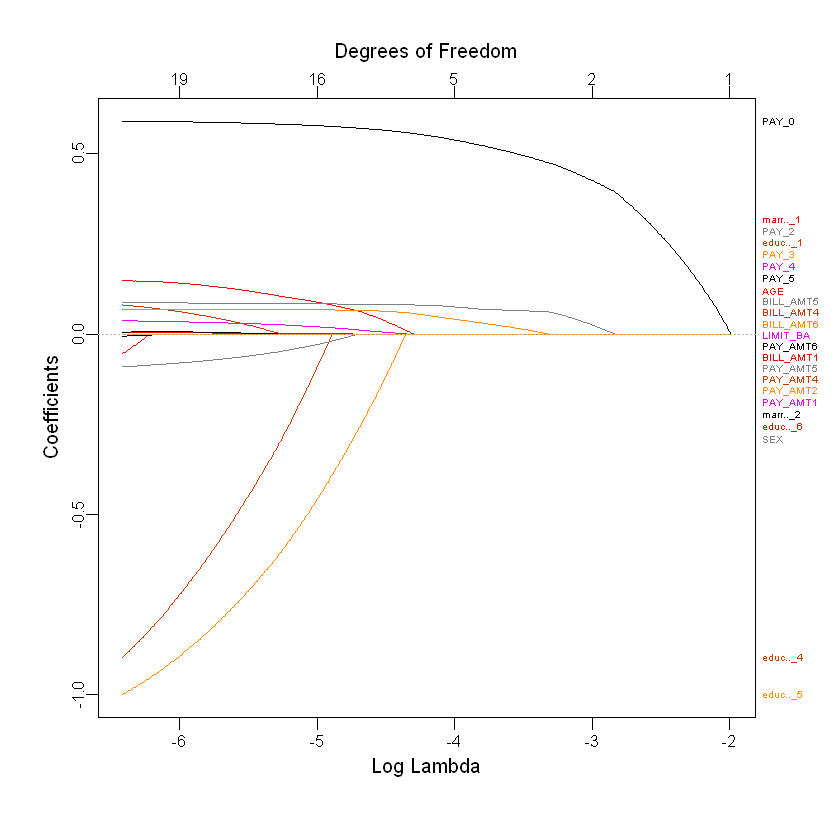

In [13]:
y = as.double(as.matrix(train_tmp$default))                                     
x = as.matrix(train_tmp[,-1])

reg = glmnet(x, y, family='binomial', alpha=1, nlambda=1000)
cv.lasso = cv.glmnet(x, y, family='binomial', alpha=1, nfolds=5, nlambda=1000)      
plot_glmnet(reg, label=TRUE, s = cv.lasso$lambda.min, xvar="lambda")
                              


As before the coefficients are shrinking towards $0$ as the penalty increases. We see the coefficient for $PAY$_$0$ is the final value to reach zero. Although we should be careful about correlation between the independent variables, this suggests that how much an individual paid in the last period is the most important feature of our classifier (at least for this specification).

Training AUC:  0.7223258
 Test AUC:  0.7107215

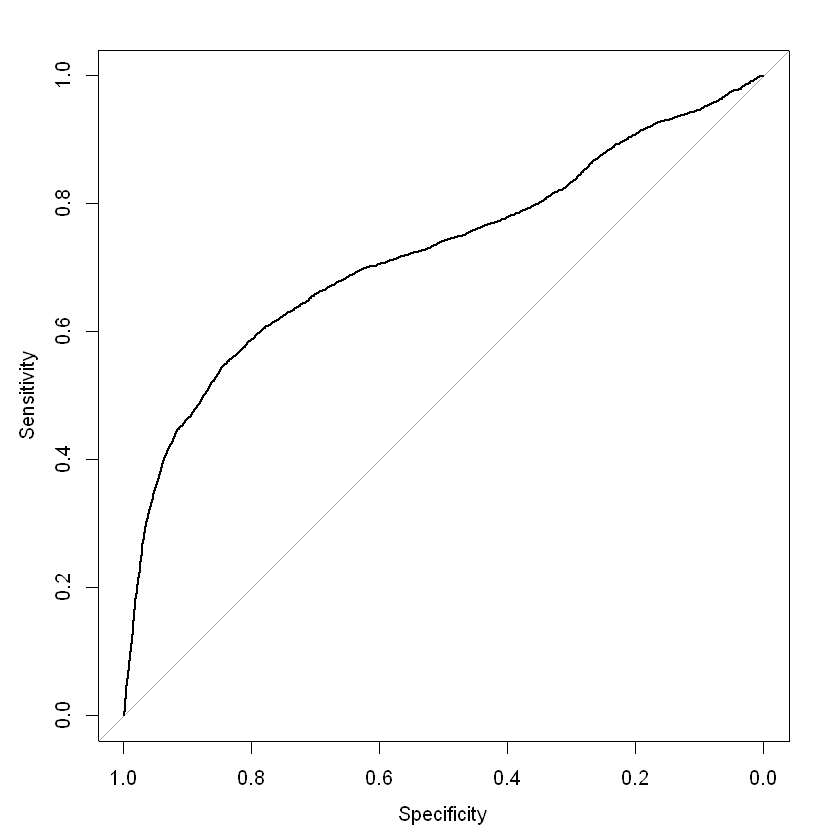

In [14]:
ROC = roc(train_tmp$default,c(predict(cv.lasso,newx=x)))
plot(ROC)
cat('Training AUC: ', auc(ROC))


xtest = as.matrix(test_tmp[,-1])
ytest = as.double(as.matrix(test_tmp$default))
ROC = roc(test_tmp$default,c(predict(cv.lasso,newx=xtest)))
cat('\n Test AUC: ', auc(ROC))



## Exercise: Module 3

In this module we saw how to split data when the outcome variable is binary to ensure proper balance across the splits. We built a simple linear classifier using logistic regression and examined the individual significance of the parameters. In addition we showed how one can compute and display marginal effects of these covariates. We introduced the concept of ROC for goodness-of-fit and examined both GAMs and shrinkage. An interesting question to ask is what would happen if we subset the sample so that the default rate is much lower, i.e. the outcome variable is very imbalanced?

1. Subsample the data such that the default rate is much lower ($0.5\%$)
2. What happens when you run the logistic regression on this data?
2. Redo the LASSO regression on this subsample
3. What do you find?


In [15]:

default1 = subset(defaults, default==1)
default0 = subset(defaults, default==0)
sample = sample_n(default1,330)

default_mod = rbind(default0,sample)


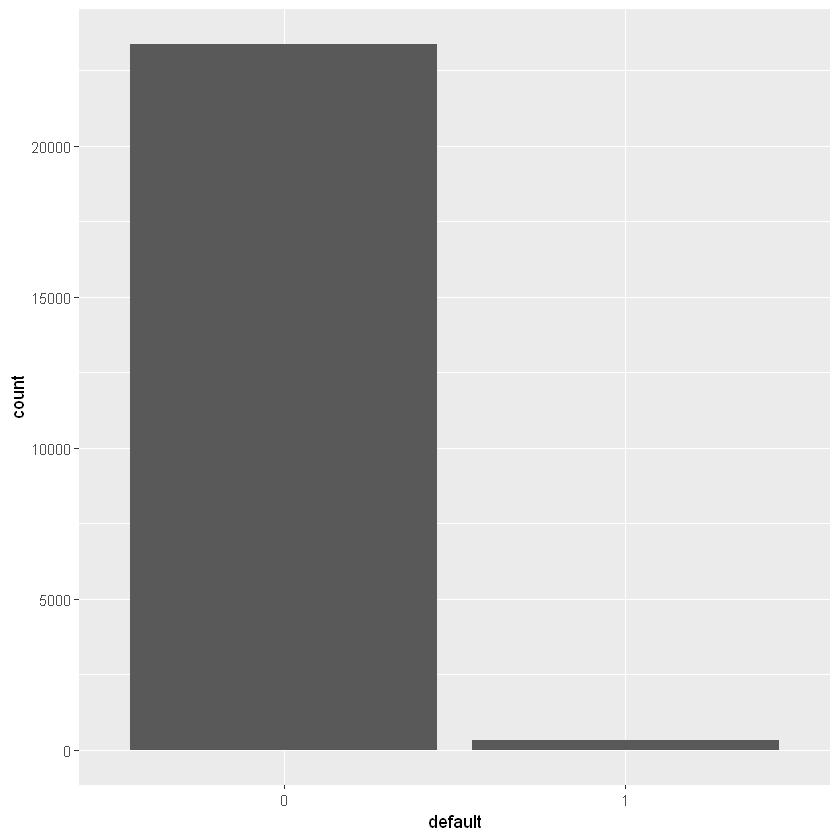

In [16]:
ggplot(default_mod, aes(default)) + geom_bar()

In [17]:
## Splitting the data
trainIndex = createDataPartition(defaults$default, p = .9,
                                  list = FALSE, 
                                  times = 1)

train_test = defaults[trainIndex,]
validation = defaults[-trainIndex,]

val = cbind(validation[c('default','SEX','AGE','LIMIT_BAL')],
            select(validation,starts_with('educ')),
            select(validation,starts_with('marr')),
            select(validation,starts_with('PAY')),
            select(validation,starts_with('BILL')))

train1 = cbind(train_test[c('default','SEX','AGE','LIMIT_BAL')],
            select(train_test,starts_with('educ')),
            select(train_test,starts_with('marr')),
            select(train_test,starts_with('PAY')),
            select(train_test,starts_with('BILL')))

tmp = createDataPartition(train1$default, p = .8,
                                  list = FALSE, 
                                  times = 1)
train_tmp = train1[tmp,]
test_tmp = train1[-tmp,]



In [18]:
Logistic = glm(default~., data= train_tmp, family='binomial')

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Notice the error we recieve. It turns out that the proportion of 0's to 1's will cause instability in the simple linear classifier. We can fix this instability by using LASSO. Why does this work? The error is telling us that some of the predictions are very large in absolute value prior to the application of the link function (in this case the logistic function). How do we get those predictions to be smaller? We can shrink them!. Let's go ahead and estimate the same model, but with a penalty term.

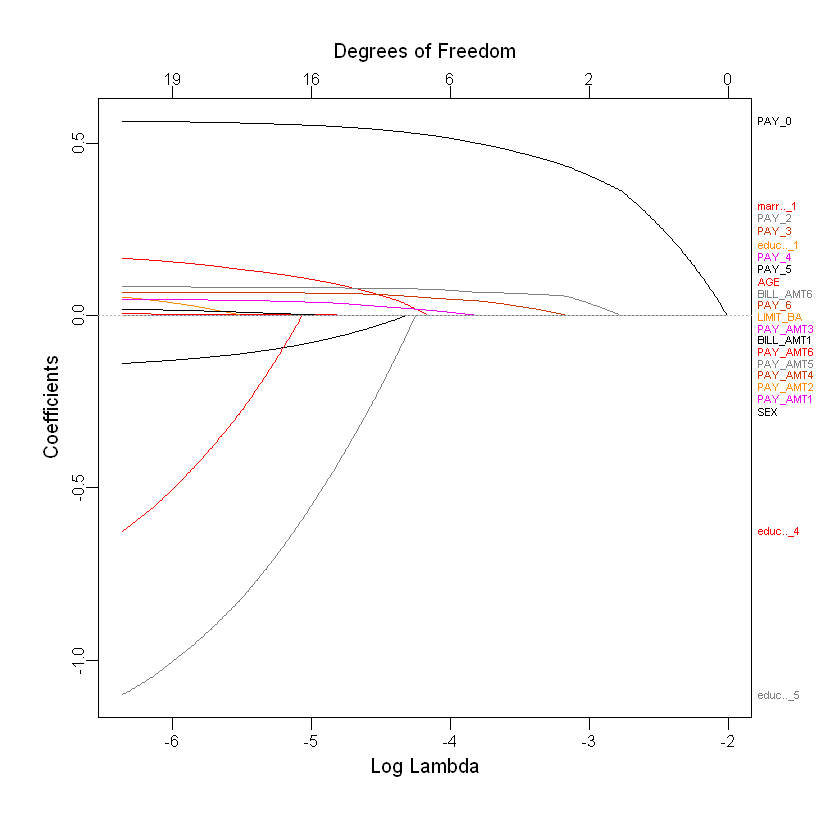

In [19]:
y = as.double(as.matrix(train_tmp$default))                                     
x = as.matrix(train_tmp[,-1])

reg = glmnet(x, y, family='binomial', alpha=1, nlambda=1000)
cv.lasso = cv.glmnet(x, y, family='binomial', alpha=1, nfolds=5, nlambda=1000)      
plot_glmnet(reg, label=TRUE, s = cv.lasso$lambda.min, xvar="lambda")
                              

Training AUC:  0.7186562
 Test AUC:  0.7204565

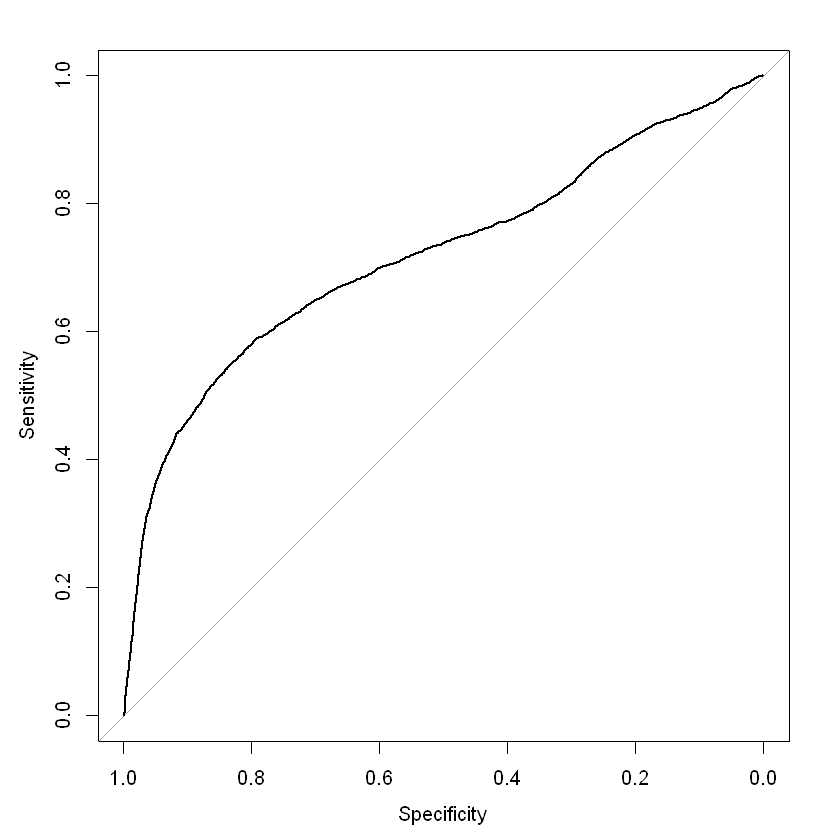

In [20]:

ROC = roc(train_tmp$default,c(predict(cv.lasso,newx=x)))
plot(ROC)
cat('Training AUC: ', auc(ROC))


xtest = as.matrix(test_tmp[,-1])
ytest = as.double(as.matrix(test_tmp$default))
ROC = roc(test_tmp$default,c(predict(cv.lasso,newx=xtest)))
cat('\n Test AUC: ', auc(ROC))


We have seen that when the proportion of non-zero to zero outcomes is very large or small we may need to consider using shrinkage methods instead of our simple linear classifier. 